In [1]:
print('hello')

hello


=== Equal-Weighted Portfolio ===
final_value: 691.1214
sharpe: -0.8716
max_drawdown: -0.5350
win_rate: 0.5366
expectancy: -0.0043

=== Volume-Weighted Portfolio ===
final_value: 766.5802
sharpe: 0.0273
max_drawdown: -0.3939
win_rate: 0.5854
expectancy: 0.0002


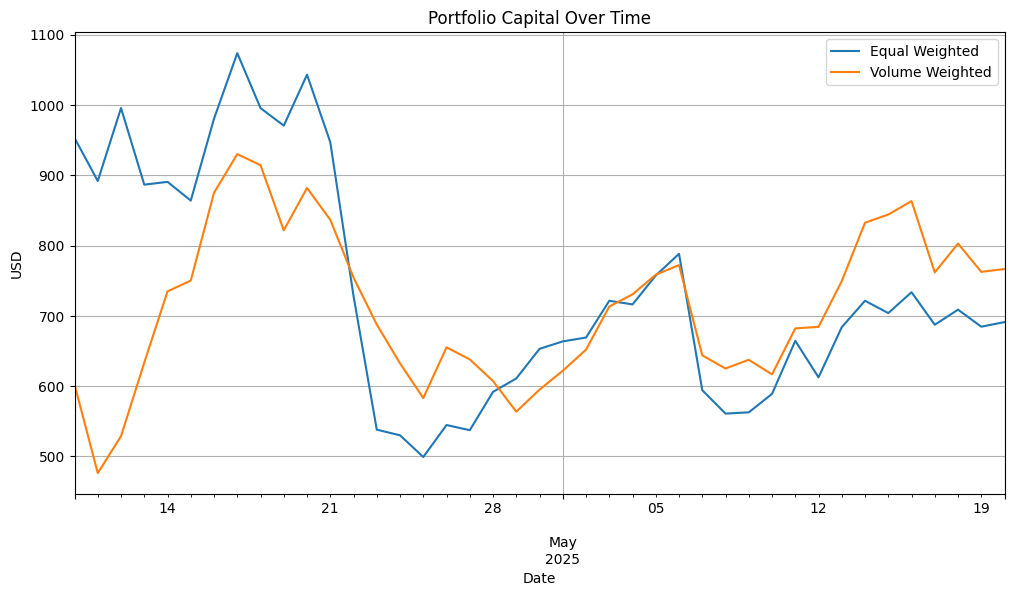

In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import os

# Load all .csv files in the folder
csv_files = glob.glob("*.csv")
returns = []
closes = []
volumes = []

for file in csv_files:
    token = os.path.splitext(file)[0]  # get token name from file
    df = pd.read_csv(file, index_col=0, parse_dates=True)

    # Rename series for clarity
    returns.append(df['return'].rename(token))
    closes.append(df['close'].rename(token))
    volumes.append(df['volume'].rename(token))

# Combine into unified DataFrames
returns_df = pd.concat(returns, axis=1).dropna()
closes_df = pd.concat(closes, axis=1).dropna()
volumes_df = pd.concat(volumes, axis=1).dropna()

# Ensure alignment of all
returns_df = returns_df.loc[closes_df.index.intersection(volumes_df.index)]
closes_df = closes_df.loc[returns_df.index]
volumes_df = volumes_df.loc[returns_df.index]

# Equal weights
equal_weights = np.repeat(1 / returns_df.shape[1], returns_df.shape[1])

# Volume-based weights using *first-day volume* (or mean volume)
initial_vol = volumes_df.iloc[0]
vol_weights = initial_vol / initial_vol.sum()

# === Backtest Portfolios ===
initial_capital = 1000
equal_port_ret = returns_df @ equal_weights
vol_port_ret = returns_df @ vol_weights

equal_port_value = (1 + equal_port_ret).cumprod() * initial_capital
vol_port_value = (1 + vol_port_ret).cumprod() * initial_capital

# === Metrics Function ===
def portfolio_metrics(port_ret, port_value):
    sharpe = port_ret.mean() / port_ret.std() * np.sqrt(365)
    drawdown = (port_value / port_value.cummax()) - 1
    max_drawdown = drawdown.min()
    win_rate = (port_ret > 0).mean()
    mean_win = port_ret[port_ret > 0].mean()
    mean_loss = port_ret[port_ret < 0].mean()
    loss_rate = 1 - win_rate
    expectancy = mean_win * win_rate + mean_loss * loss_rate

    return {
        'final_value': port_value.iloc[-1],
        'sharpe': sharpe,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'expectancy': expectancy
    }

# Compute and print metrics
equal_metrics = portfolio_metrics(equal_port_ret, equal_port_value)
vol_metrics = portfolio_metrics(vol_port_ret, vol_port_value)

print("=== Equal-Weighted Portfolio ===")
for k, v in equal_metrics.items():
    print(f"{k}: {v:.4f}")

print("\n=== Volume-Weighted Portfolio ===")
for k, v in vol_metrics.items():
    print(f"{k}: {v:.4f}")

# === Plot ===
plt.figure(figsize=(12, 6))
equal_port_value.plot(label="Equal Weighted")
vol_port_value.plot(label="Volume Weighted")
plt.title("Portfolio Capital Over Time")
plt.ylabel("USD")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import pandas as pd
import numpy as np
import os

folder_path = './'  # Adjust if needed

summary_list = []

for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        token_name = file.replace('.csv', '')
        df = pd.read_csv(os.path.join(folder_path, file), index_col=0)

        df = df.dropna(subset=['return'])

        # Metrics
        days = len(df)
        total_return = (df['close'].iloc[-1] / df['close'].iloc[0]) - 1
        sharpe_ratio = df['return'].mean() / df['return'].std() * np.sqrt(365)
        max_drawdown = df['drawdown'].min()
        win_rate = (df['return'] > 0).mean()

        mean_win = df[df['return'] > 0]['return'].mean()
        mean_loss = df[df['return'] < 0]['return'].mean()
        loss_rate = 1 - win_rate
        expectancy = mean_win * win_rate + mean_loss * loss_rate

        summary_list.append({
            'Token': token_name,
            'No.Days': days,
            'Sharpe': round(sharpe_ratio, 4),
            'Total Return': round(total_return, 4),
            'Max Drawdown': round(max_drawdown, 4),
            'Win Rate': round(win_rate, 4),
            'Expectancy': round(expectancy, 4)
        })

# Create summary DataFrame
summary_df = pd.DataFrame(summary_list)
summary_df = summary_df.sort_values(by='Sharpe', ascending=False).reset_index(drop=True)

# View it
print(summary_df)


     Token  No.Days  Sharpe  Total Return  Max Drawdown  Win Rate  Expectancy
0     TALK       57  4.4254        2.6564       -0.4056    0.6140      0.0314
1  MOONKIN       80  2.1024       -0.9565       -0.9973    0.5875      0.0354
2     DEAI       99  1.4260        0.2745       -0.7205    0.5152      0.0081
3   PROMPT       41  0.1086       -0.2795       -0.5797    0.5854      0.0007
4   COCORO       74 -0.3440       -0.9779       -0.9839    0.5405     -0.0050


<Axes: title={'center': 'Sharpe vs. Total Return'}, xlabel='Sharpe', ylabel='Total Return'>

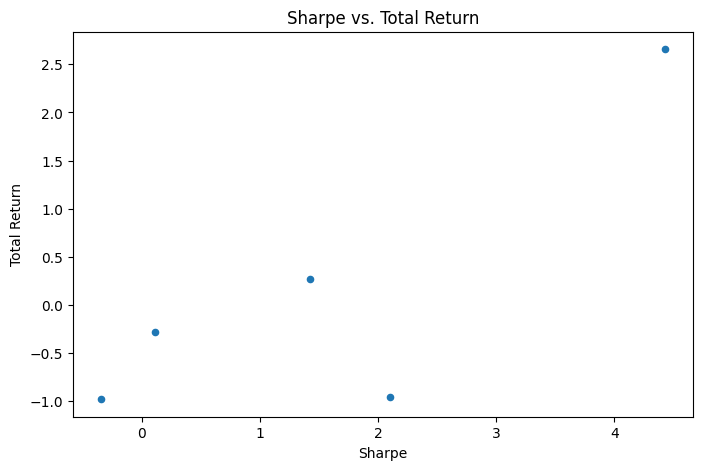

In [7]:
summary_df.plot.scatter(x='Sharpe', y='Total Return', figsize=(8,5), title="Sharpe vs. Total Return")